<small><i>This notebook was put together by Jake VanderPlas for UW's [Astro 599](http://www.astro.washington.edu/users/vanderplas/Astr599_2014/) course. Source and license info is on [GitHub](https://github.com/jakevdp/2014_fall_ASTR599/).</i></small>

# Optimization and Minimization

*adapted from material by Andrew Becker*

Today we're going to go over several methods for **fitting a model to data**.

## Straight-line Fit

A classic example of this is finding a "line of best fit": that is, given some data $\{x_i, y_i\}$, find a best-fit line defined by the slope $m$ and the intercept $b$. Below we'll think more generally about model fitting and show some means of doing model fitting in Python.

We'll present some of the formalism (you can read about the statistical details elsewhere), and show how to approach this in Python.

Let's create some fake data to try this out:

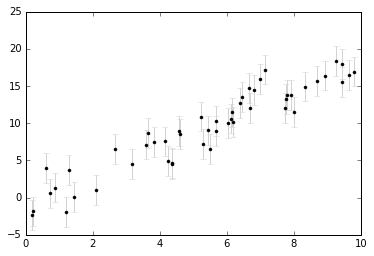

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 50
m_true = 2
b_true = -1
dy = 2.0

np.random.seed(0)
xdata = 10 * np.random.random(N)
ydata = np.random.normal(b_true + m_true * xdata, dy)

plt.errorbar(xdata, ydata, dy,
             fmt='.k', ecolor='lightgray');

For our straight-line, the model is given by

$$
y_{model}(x) = mx + b
$$

Given this model, we can define some metric of "goodness of fit". One commonly used metric is the $\chi^2$, defined as follows:

$$
\chi^2 = \sum_{i=1}^N \left(\frac{y_i - y_{model}(x)}{\sigma_y}\right)^2
$$

(Note that if you're used to thinking in terms of likelihood, the likelihood here is $\mathcal{L}\propto e^{-\chi^2}$)
Given this, our task is to minimize the $\chi^2$ with respect to the model parameters $\theta = [m, b]$ in order to find the best fit.

### Method 1: using ``scipy.optimize.fmin``

The ``scipy.optimize`` package has many optimization routines which are useful in a variety of situations:

In [2]:
from scipy import optimize
optimize?

The simplest go-to method is ``optimize.fmin``, which minimizes any given function

In [3]:
optimize.fmin?

We'll start by defining a function for our $\chi^2$:

In [4]:
def chi2(theta, x, y, dy):
    # theta = [b, m]
    return np.sum(((y - theta[0] - theta[1] * x) / dy) ** 2)

Next we call ``fmin`` to optimize this function. We need to give an initial guess for $\theta$:

In [5]:
theta_guess = [0, 1]
theta_best = optimize.fmin(chi2, theta_guess, args=(xdata, ydata, dy))
print(theta_best)

Optimization terminated successfully.
         Current function value: 42.776378
         Iterations: 70
         Function evaluations: 129
[-1.01441373  1.93854462]


Now let's plot our data and error:

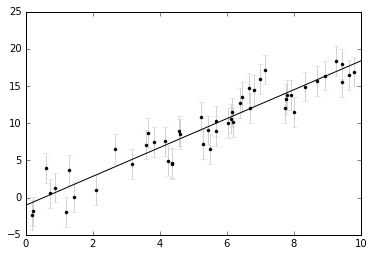

In [6]:
xfit = np.linspace(0, 10)
yfit = theta_best[0] + theta_best[1] * xfit

plt.errorbar(xdata, ydata, dy,
             fmt='.k', ecolor='lightgray');
plt.plot(xfit, yfit, '-k');

Now you can see that we've found a best-fit line for our data!

### Method 2: Least Squares Fitting

The function we used above, ``scipy.optimize.fmin``, is a general function which works for (nearly) any cost function.
Above we've used it for a linear model; it turns out that there are much simpler ways to find results for a linear model. One of these is ``scipy.optimize.leastsq``:

In [7]:
optimize.leastsq?

Here rather than computing the $\chi^2$, we compute an array of deviations from the model:

In [8]:
def deviations(theta, x, y, dy):
    return (y - theta[0] - theta[1] * x) / dy

theta_best, ier = optimize.leastsq(deviations, theta_guess, args=(xdata, ydata, dy))
print(theta_best)

[-1.01442017  1.93854659]


Again, we can plot the result:

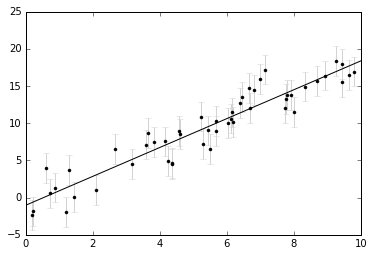

In [9]:
yfit = theta_best[0] + theta_best[1] * xfit

plt.errorbar(xdata, ydata, dy,
             fmt='.k', ecolor='lightgray');
plt.plot(xfit, yfit, '-k');

The nice thing about least squares fitting is that it includes a means of estimating the error on the fit parameters, which we can find by setting the argument ``full_output=True``

In [10]:
results = optimize.leastsq(deviations, theta_guess,
                           args=(xdata, ydata, dy),
                           full_output=True)
theta_best = results[0]
covariance = results[1]

print(covariance)

[[ 0.39232876 -0.05805744]
 [-0.05805744  0.01079204]]


This gives the uncertainty covariance of the parameters; here we see that they are nearly uncorrelated (the off-diagonal terms are close to zero) so we can approximate the fit as follows:

In [11]:
print("y = ({0:.2f} +/- {1:.2f})x + ({2:.2f} +/- {3:.2f})"
      "".format(theta_best[1], np.sqrt(covariance[1, 1]),
                theta_best[0], np.sqrt(covariance[0, 0])))

y = (1.94 +/- 0.10)x + (-1.01 +/- 0.63)


Apparently the slope is much less certain than the intercept.

### Method 3: Linear Algebra

Getting even more specialized, for a linear equation like the one above, it is possible to solve for the slope and intercept via a straightforward linear algebraic operation. For the case where all errors $dy$ are the same, we simply construct matrices

$$
X = \left[
\begin{array}{lllll}
1&1&1&\cdots&1\\
x_1&x_2&x_3&\cdots&x_N
\end{array}
\right]^T
$$

$$
y = [y_1, y_2, y_3, \cdots y_N]^T
$$

We want to solve the linear equation

$$
y = X\theta
$$

for the optimal $\theta$. We can solve this equation using either ``np.linalg.solve`` (for well-determined, full-rank problems) or ``np.linalg.lstsq`` (for under-determined problems)

In [12]:
np.linalg.solve?

In [13]:
np.linalg.lstsq?

In [12]:
Xdata = np.vstack([np.ones_like(xdata), xdata]).T
theta_best, resid, rank, singvals = np.linalg.lstsq(Xdata, ydata)
print(theta_best)

[-1.01442017  1.93854659]


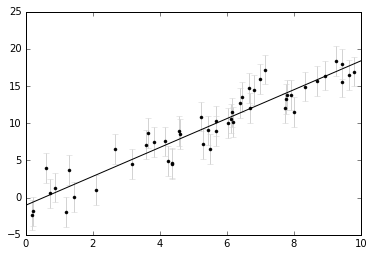

In [13]:
yfit = theta_best[0] + theta_best[1] * xfit

plt.errorbar(xdata, ydata, dy,
             fmt='.k', ecolor='lightgray');
plt.plot(xfit, yfit, '-k');

It is also possible to construct appropriate $X$ and $y$ matrices for the case when the errors are not the same; that construction can be found in many introductory texts.

As a side note, you should realize that ``np.linalg.lstsq`` is essentially just a wrapper around some simple matrix operations; we can do them ourselves as follows:

In [14]:
# compute the least-squares solution by-hand!
theta_best = np.linalg.solve(np.dot(Xdata.T, Xdata),
                             np.dot(Xdata.T, ydata))

covariance = dy ** 2 * np.linalg.inv(np.dot(Xdata.T, Xdata))

print("y = ({0:.2f} +/- {1:.2f})x + ({2:.2f} +/- {3:.2f})"
      "".format(theta_best[1], np.sqrt(covariance[1, 1]),
                theta_best[0], np.sqrt(covariance[0, 0])))

y = (1.94 +/- 0.10)x + (-1.01 +/- 0.63)


Notice that this is the same result we got above.
You can consult an intro statistics book to see where these expressions come from.

### Optimization in Python: Summary

- For *general* optimization problems, you can use ``scipy.optimize.fmin``.

- For *least-squares* optimization problems, you can use ``scipy.optimize.leastsq``.

- For *linear least-squares* optimization problems, you can use ``np.linalg.lstsq``, or you can go through the formalism and compute the result via standard linear algebraic operations.

***

### Polynomial fit

Sometimes you just need a polynomial fit because you're an astronomer. For those times, you can use numpy's functions `polyfit` and `polyval`.

`numpy.polyfit` takes the $(x, y)$ data that you'd like to fit and the polynomial order you'd like to fit it with, and returns the least-squares polynomial fit coefficients.

In [17]:
polynomial_order = 2

polynomial_coefficients = np.polyfit(xdata, ydata, polynomial_order)

`numpy.polyval` evaluates the polynomial described by those coefficients, at a series of $x$ values that you provide: 

<Container object of 3 artists>

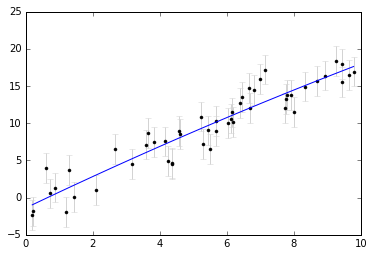

In [20]:
ypolyfit = np.polyval(polynomial_coefficients, xdata)

plt.errorbar(xdata, ydata, dy,
             fmt='.k', ecolor='lightgray')

# We need to sort the values because xdata is not in order
plt.errorbar(xdata[np.argsort(xdata)], ypolyfit[np.argsort(xdata)])

***

### Markov Chain Monte Carlo

If and only if your particular problem meets certain criteria, you may want to use MCMC to fit your line. There's a great package for using MCMC in Python called [emcee](http://dan.iel.fm/emcee/current/) that we'll demonstrate here.

If you haven't already installed emcee, run:
```
conda install emcee
pip install corner
```

A full discussion of what MCMC is and how it works is beyond the scope of this lesson. The lesson is taken directly from Dan Foreman-Mackey's line-fitting example in the [emcee docs](https://github.com/dfm/emcee/blob/master/examples/line.py).

In this example, we'll take make randomly-generated data that follow a linear trend:

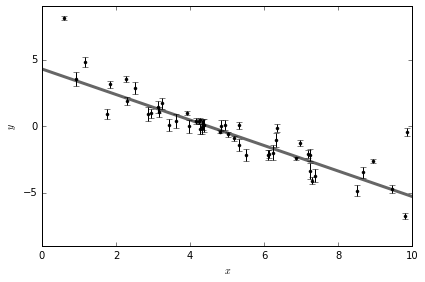

In [4]:
import emcee
import corner
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator

# Reproducible results!
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

# Plot the dataset and the true model.
xl = np.array([0, 10])
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.tight_layout()
pl.show()

The gray line shows the true trend that the data were drawn from.

As we showed above, a linear model can be fit with least-squares, so let's do that: 

In [5]:
# Do the least-squares fit and compute the uncertainties.
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print("""Least-squares results:
    m = {0} ± {1} (truth: {2})
    b = {3} ± {4} (truth: {5})
""".format(m_ls, np.sqrt(cov[1, 1]), m_true, b_ls, np.sqrt(cov[0, 0]), b_true))

Least-squares results:
    m = -1.1040757010910942 ± 0.016229892552329806 (truth: -0.9594)
    b = 5.440555250231949 ± 0.09090827914304528 (truth: 4.294)



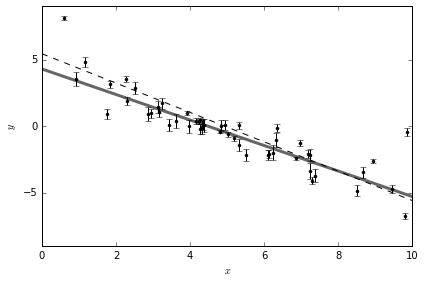

In [7]:
# Plot the least-squares result.
pl.plot(xl, m_ls*xl+b_ls, "--k")
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.tight_layout()

You can see that the least-squares fit is close to the real solution, but biased by the small measurement uncertainties. For that reason, we'll include a term in our likelihood that increases the errorbars by some fractional amount.

### Running MCMC

Now we'll define a few functions: 

* the *prior* is defined in `lnprior`, which is uniform for the slope and intercept, and log-uniform for the fractional uncertainty parameter $f$
* the *log-likelihood* in `lnlike`, which is the log of the $\chi^2$
* the *log-probability* in `lnprob`, which returns the probability after evaluating the prior and likelihood

In [ ]:
# Define the probability function as likelihood * prior.
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

With these functions defined, we can maximize the probability using a standard minimizer, which will give us the maximumum probability values for each parameter: 

Maximum likelihood result:
    m = -1.0030087100835143 (truth: -0.9594)
    b = 4.528315213784724 (truth: 4.294)
    f = 0.45364487084994887 (truth: 0.534)



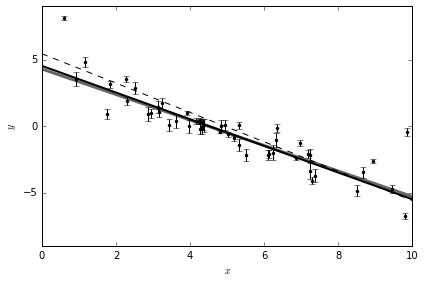

In [11]:
# Find the maximum likelihood value.
chi2 = lambda *args: -2 * lnlike(*args)
result = op.minimize(chi2, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print("""Maximum likelihood result:
    m = {0} (truth: {1})
    b = {2} (truth: {3})
    f = {4} (truth: {5})
""".format(m_ml, m_true, b_ml, b_true, np.exp(lnf_ml), f_true))

# Plot the maximum likelihood result.
pl.plot(xl, m_ml*xl+b_ml, "k", lw=2)
pl.plot(xl, m_ls*xl+b_ls, "--k")
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.tight_layout()

That fit looks better! The purpose here for using MCMC is to characterize the uncertainties on those maximum-likelihood parameters. I'm **not** going to start a discussion of Bayesian statistics, but I **will** show you how to use MCMC to get those uncertainties.

Below, we will run 100 walkers for 500 steps, with initial positions distributed near the maximum-likelihood values that we found earlier. Then we'll plot the values of the chains for each step.

Running MCMC...
Done.


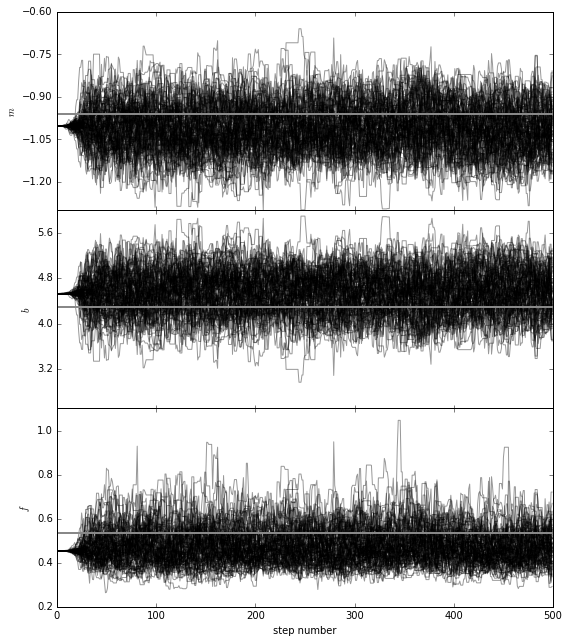

In [13]:
# Set up the sampler.
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, 500, rstate0=np.random.get_state())
print("Done.")

pl.clf()
fig, axes = pl.subplots(3, 1, sharex=True, figsize=(8, 9))
axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(m_true, color="#888888", lw=2)
axes[0].set_ylabel("$m$")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(b_true, color="#888888", lw=2)
axes[1].set_ylabel("$b$")

axes[2].plot(np.exp(sampler.chain[:, :, 2]).T, color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(f_true, color="#888888", lw=2)
axes[2].set_ylabel("$f$")
axes[2].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)
pl.show()

You can see that the initial position is near the final solution, but not identical to it.

We will assume that the chains are "burned in" after 50 steps in the steps below, as we visualize the posterior distributions below:

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


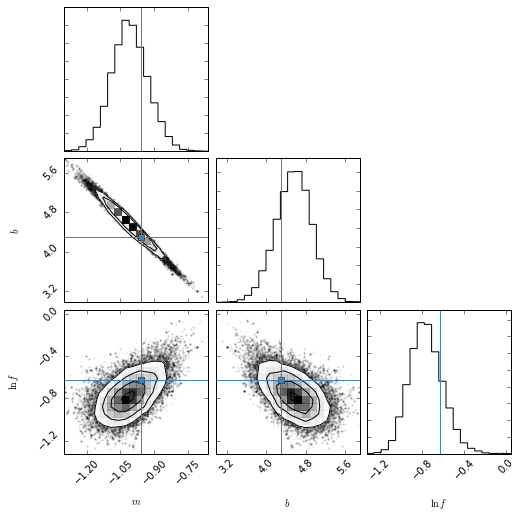

In [16]:
# Make the triangle plot.
burnin = 50
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])

pl.show()

The blue lines and points above show the parameters that we used in the very first step to generate the dataset, and we've recovered each of those parameters to within about 1$\sigma$.

Below, let's draw some combinations of the parameters from the posterior distributions, and plot the model below: 

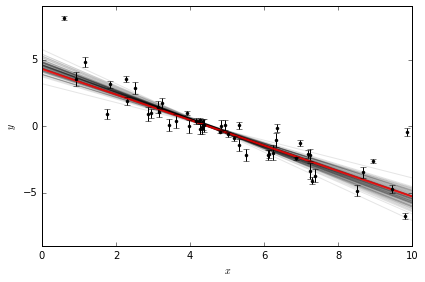

MCMC result:
    m = -1.0105930358106614 +0.08181878003930221 -0.07678654019907083 (truth: -0.9594)
    b = 4.560000037958832 +0.35236474316170163 -0.3761367006552234 (truth: 4.294)
    f = 0.46375341063409925 +0.08334536540124426 -0.0638304332164476 (truth: 0.534)



In [17]:
# Plot some samples onto the data.
pl.figure()
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.tight_layout()
plt.show()

# Compute the quantiles.
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print("""MCMC result:
    m = {0[0]} +{0[1]} -{0[2]} (truth: {1})
    b = {2[0]} +{2[1]} -{2[2]} (truth: {3})
    f = {4[0]} +{4[1]} -{4[2]} (truth: {5})
""".format(m_mcmc, m_true, b_mcmc, b_true, f_mcmc, f_true))